# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** Team #4
**Members (GitHub handles):** SanjanaMohan34, knittala, akoripal, lily-larson

**GitHub Repo URL:** https://github.com/SanjanaMohan34/MGMT_467_Team4

**Looker Studio Dashboard (public link):** Team: https://lookerstudio.google.com/u/0/reporting/e440aa05-d8a4-42df-88c1-8af01e1f9905/page/eGIcF/edit

Individual: https://lookerstudio.google.com/u/0/reporting/902b4561-2a46-4d87-be78-fcd65f45efd6/page/HEHcF/edit

> **Scenario:** NYC DOT has asked your team to analyze the public Citi Bike program and recommend strategies to improve bike availability and engagement. You will use BigQuery + Gemini to conduct AI‑assisted EDA and publish an executive dashboard.

## ✅ Submission Checklist (Team → Brightspace)
- [ ] GitHub repository link (source of record)
- [ ] Looker Studio dashboard link
- [ ] This notebook committed to GitHub with prompts and results

### ✅ Submission Checklist (Individual → Brightspace)
- [ ] `Contribution_Reflection.pdf` (with commit/PR evidence + peer eval)

## 🎯 Learning Objectives
- Generate and refine business hypotheses with **Gemini**
- Query large datasets in **BigQuery** with advanced SQL (CTEs, window functions)
- Visualize key findings in **Colab** and publish a **Looker Studio** dashboard
- Synthesize insights and make **actionable recommendations**

## 🧰 Setup
> Run the cells below to connect Colab to Google Cloud & BigQuery.

In [25]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "mgmt467-project1"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: mgmt467-project1


In [26]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

## 🧪 Dataset
We will use **Citi Bike Trips**: `bigquery-public-data.new_york_citibike.citibike_trips`  
Feel free to explore additional public datasets if needed.

## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **Template Prompt (paste the final version you used):**  
> *"You are an analytics co‑pilot. Propose 6 high‑value, testable business questions about the Citi Bike dataset (tripduration, stations, user types, time-of-day/week, gender). Return as bullets with a 1-2 sentence description with suggested SQL hints."*

**Selected Hypotheses**
1. Is there a difference in trip patterns between male and female riders? This could reveal insights for targeted marketing or service adjustments. SQL Hint: Use COUNT(*) and GROUP BY gender and potentially include time-based grouping.
2. What is the average distance traveled per trip, and how does it vary by user type and time of day? This can provide insights into how the service is being used for commuting versus leisure. SQL Hint: You would need to calculate distance from station coordinates or use available distance data if present, then use AVG() and GROUP BY usertype, EXTRACT(HOUR FROM starttime).
3. Are there specific station pairs (start to end) that are significantly more popular than others? This can highlight key routes and inform station capacity planning. SQL Hint: Use COUNT(*) and GROUP BY start_station_name, end_station_name and order by count.

## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Prompt Log

**My Prompt:** Give me a SQL query exploring the following question: Is there a difference in trip patterns between male and female riders?

**Key Suggestions:**

Why we're looking into this: This could reveal insights for targeted marketing or service adjustments.

SQL Hint: Use COUNT(*) and GROUP BY gender and potentially include time-based grouping.

Here's the FROM query we will use to access the data: FROM `bigquery-public-data.new_york_citibike.citibike_trips`



In [27]:
# Hypothesis A — SQL (store results in a Pandas DataFrame)
query_hyp_a = r"""
-- Your final SQL for Hypothesis A goes here.
SELECT
    gender,
    COUNT(*) AS trip_count
FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
    gender IS NOT NULL AND gender != '0' -- Filter out unknown gender, assuming '0' is the string representation
GROUP BY
    gender
ORDER BY
    trip_count DESC
"""

df_hyp_a = client.query(query_hyp_a).to_dataframe()
df_hyp_a.head()

,gender,trip_count
0,male,35611787
1,female,11376412
2,unknown,6120522
3,,5828994


**Interpretation:** The query output shows a considerable difference in trip counts between male and female riders. Male riders seem to be taking substantially more trips. There is also a considerable number of trips where the gender is unknown or not provided, which could impact the overall analysis. This could be because the data is incomplete/not processed for null values. Because of this, we should account for error while interpreting our findings.

## Validation for hypothesis A

In [28]:
# Code to validate gender distribution query
query_validation = r"""
SELECT
    COUNT(*) AS total_trips,
    COUNTIF(gender IS NULL OR gender = '' OR gender = '0') AS null_gender_trips
FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
"""

validation_df = client.query(query_validation).to_dataframe()
display(validation_df)

,total_trips,null_gender_trips
0,58937715,5828994


---

### Hypothesis B — Prompt Log

**My Prompt:** Give me a SQL query exploring the following question: What is the average distance traveled per trip, and how does it vary by user type and time of day?Arrange the average distance column in descending order. Use CTEs.

**Key Suggestions:**

Why we're exploring this question: This can provide insights into how the service is being used for commuting versus leisure.

SQL Hint: You would need to calculate distance from station coordinates or use available distance data if present, then use AVG() and GROUP BY usertype, EXTRACT(HOUR FROM starttime).

Here's the FROM query we will use to access the data: FROM `bigquery-public-data.new_york_citibike.citibike_trips`

In [29]:
# Hypothesis B — SQL
query_hyp_b = r"""
-- Your final SQL for Hypothesis B goes here.
WITH TripDistances AS (
    SELECT
        usertype,
        starttime,
        ACOS(
            SIN(start_station_latitude * ACOS(-1) / 180) * SIN(end_station_latitude * ACOS(-1) / 180) +
            COS(start_station_latitude * ACOS(-1) / 180) * COS(end_station_latitude * ACOS(-1) / 180) *
            COS((start_station_longitude - end_station_longitude) * ACOS(-1) / 180)
        ) * 6371 AS distance_km -- Earth's radius in kilometers
    FROM
        `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE
        start_station_latitude IS NOT NULL AND end_station_latitude IS NOT NULL AND
        start_station_longitude IS NOT NULL AND end_station_longitude IS NOT NULL AND
        (start_station_latitude != end_station_latitude OR start_station_longitude != end_station_longitude) -- Exclude rows where start and end coordinates are the same
)
SELECT
    usertype,
    EXTRACT(HOUR FROM starttime) AS hour_of_day,
    AVG(distance_km) AS average_distance_km
FROM
    TripDistances
GROUP BY
    usertype,
    hour_of_day
ORDER BY
    average_distance_km DESC
"""
df_hyp_b = client.query(query_hyp_b).to_dataframe()
df_hyp_b.head()

,usertype,hour_of_day,average_distance_km
0,Customer,8,2.304420
1,Customer,7,2.244699
2,Customer,9,2.191137
3,Customer,18,2.187361
4,Customer,19,2.149897


**Follow Up Prompt:** Write a query to obtain two different tables, one for customers and another for subscribers.

In [30]:
# Separate tables for Customer and Subscriber
df_customer = df_hyp_b[df_hyp_b['usertype'] == 'Customer'].sort_values(by='average_distance_km', ascending=False).head()
df_subscriber = df_hyp_b[df_hyp_b['usertype'] == 'Subscriber'].sort_values(by='average_distance_km', ascending=False).head()

print("Customer Data:")
display(df_customer)

print("\nSubscriber Data:")
display(df_subscriber)

Customer Data:


,usertype,hour_of_day,average_distance_km
0,Customer,8,2.304420
1,Customer,7,2.244699
2,Customer,9,2.191137
3,Customer,18,2.187361
4,Customer,19,2.149897



Subscriber Data:


,usertype,hour_of_day,average_distance_km
22,Subscriber,8,1.974516
24,Subscriber,7,1.949519
26,Subscriber,17,1.934140
27,Subscriber,18,1.920801
28,Subscriber,19,1.797780


**Interpretation:** The output shows the average estimated distance of Citi Bike trips in kilometers, ordered from longest average distance to shortest. We can see that in general, customers seem to have the longest average distance travelled when compared to subscribers for the same time frame of the day. This could be because the customers are more likely to invest in longer trips when they do make the decision to purchase a trip whereas subscribers might not feel the pressure to "make the most of a trip" in the same way. For both categories, the top 5 hours of the day where the most average distance in km is covered is 8 am, 7 am, 9 am, 6 pm and 7 pm. This could be because these are the peak school/office start and end times, causing people to travel more.

## Validation for hypothesis B

In [31]:
# Simple validation code for Hypothesis B query
query_validation_b = r"""
SELECT
    COUNT(*) AS total_trips,
    COUNTIF(
        start_station_latitude IS NULL OR end_station_latitude IS NULL OR
        start_station_longitude IS NULL OR end_station_longitude IS NULL
    ) AS trips_with_null_coordinates,
    COUNTIF(
        start_station_latitude IS NOT NULL AND end_station_latitude IS NOT NULL AND
        start_station_longitude IS NOT NULL AND end_station_longitude IS NOT NULL AND
        start_station_latitude = end_station_latitude AND start_station_longitude = end_station_longitude
    ) AS trips_with_identical_non_null_coordinates,
    COUNTIF(
        start_station_latitude IS NOT NULL AND end_station_latitude IS NOT NULL AND
        start_station_longitude IS NOT NULL AND end_station_longitude IS NOT NULL AND
        (start_station_latitude != end_station_latitude OR start_station_longitude != end_station_longitude)
    ) AS trips_included_in_cte
FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
"""

validation_b_df = client.query(query_validation_b).to_dataframe()
display(validation_b_df)

# Add print statements
total_trips_b = validation_b_df['total_trips'].iloc[0]
null_coord_trips = validation_b_df['trips_with_null_coordinates'].iloc[0]
identical_non_null_trips = validation_b_df['trips_with_identical_non_null_coordinates'].iloc[0]
trips_included = validation_b_df['trips_included_in_cte'].iloc[0]

print(f"\nTotal trips in the dataset: {total_trips_b}")
print(f"Trips with null start or end coordinates: {null_coord_trips}")
print(f"Trips with identical (non-null) start and end coordinates: {identical_non_null_trips}")
print(f"Trips included in the Hypothesis B analysis (non-null/different coordinates): {trips_included}")
print(f"Total trips - Null trips - Identical non-null trips = {total_trips_b - null_coord_trips - identical_non_null_trips}")
print(f"Trips included in CTE: {trips_included}")

,total_trips,trips_with_null_coordinates,trips_with_identical_non_null_coordinates,trips_included_in_cte
0,58937715,5828994,1144735,51963986



Total trips in the dataset: 58937715
Trips with null start or end coordinates: 5828994
Trips with identical (non-null) start and end coordinates: 1144735
Trips included in the Hypothesis B analysis (non-null/different coordinates): 51963986
Total trips - Null trips - Identical non-null trips = 51963986
Trips included in CTE: 51963986


---

### Hypothesis C — Prompt Log

**My Prompt:** Give me a SQL query exploring the following question: Are there specific station pairs (start to end) that are significantly more popular than others?

**Key Suggestions:**

Why we're exploring this: This can highlight key routes and inform station capacity planning.

SQL Hint: Use COUNT(*) and GROUP BY start_station_name, end_station_name and order by count. Use CTEs and at least one window function.

Here's the FROM query we will use to access the data: FROM bigquery-public-data.new_york_citibike.citibike_trips

In [32]:
# Hypothesis C — SQL
query_hyp_c = r"""
-- Your final SQL for Hypothesis C goes here.
WITH StationPairCounts AS (
    SELECT
        start_station_name,
        end_station_name,
        COUNT(*) AS trip_count
    FROM
        `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE
        start_station_name IS NOT NULL AND end_station_name IS NOT NULL
    GROUP BY
        start_station_name,
        end_station_name
)
SELECT
    start_station_name,
    end_station_name,
    trip_count,
    RANK() OVER (ORDER BY trip_count DESC) as rank
FROM
    StationPairCounts
ORDER BY
    rank
LIMIT 10 -- Display the top 10 most popular pairs
"""
df_hyp_c = client.query(query_hyp_c).to_dataframe()
df_hyp_c.head(10)

,start_station_name,end_station_name,trip_count,rank
0,,,5828994,1
1,Central Park S & 6 Ave,Central Park S & 6 Ave,55703,2
2,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,25573,3
3,Centre St & Chambers St,Centre St & Chambers St,19670,4
4,Broadway & W 60 St,Broadway & W 60 St,19475,5
5,12 Ave & W 40 St,West St & Chambers St,18667,6
6,W 21 St & 6 Ave,9 Ave & W 22 St,17509,7
7,W 21 St & 6 Ave,W 22 St & 10 Ave,15120,8
8,West St & Chambers St,12 Ave & W 40 St,14353,9
9,West St & Chambers St,West St & Chambers St,14165,10


**Interpretation:** This highlights the routes with the highest numer of riders, which is important information for station capacity planning and bike distribution efforts.

The first row with the blank station names and a very high trip count is likely due to error in information collection where there might not have been proper recording of start/end stations of if a customer didn't start/end their trip properly. The next three highest stations have the same start and end points indicating round trips.



## Validation for hypothesis C:

In [33]:
# Simple validation code for Hypothesis C query
query_validation_c = r"""
SELECT
    COUNT(*) AS total_trips,
    COUNTIF(start_station_name IS NULL OR end_station_name IS NULL) AS trips_with_null_station_names
FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
"""

validation_c_df = client.query(query_validation_c).to_dataframe()
display(validation_c_df)

,total_trips,trips_with_null_station_names
0,58937715,0


## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

**My Prompt:** Create at least 3 charts that communicate your findings. Keep charts readable and labeled. Use matplotlib (no specific styles required). create one chart for hypothesis A, one for Hypothesis B and one for Hypothesis C. The code for each chart should be in a different cell

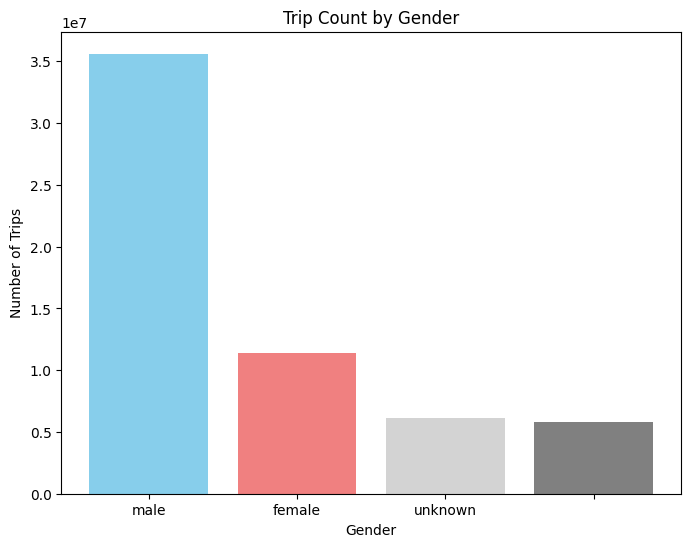

In [34]:
# Chart for Hypothesis A (Gender Distribution)
plt.figure(figsize=(8, 6))
plt.bar(df_hyp_a['gender'], df_hyp_a['trip_count'], color=['skyblue', 'lightcoral', 'lightgray', 'grey'])
plt.xlabel('Gender')
plt.ylabel('Number of Trips')
plt.title('Trip Count by Gender')
plt.show()

**Interpretation:** This bar chart illustrates the distribution of trip counts across different genders. We see that male riders take significantly more trips than female riders, with a notable portion of trips having unknown or unspecified gender.

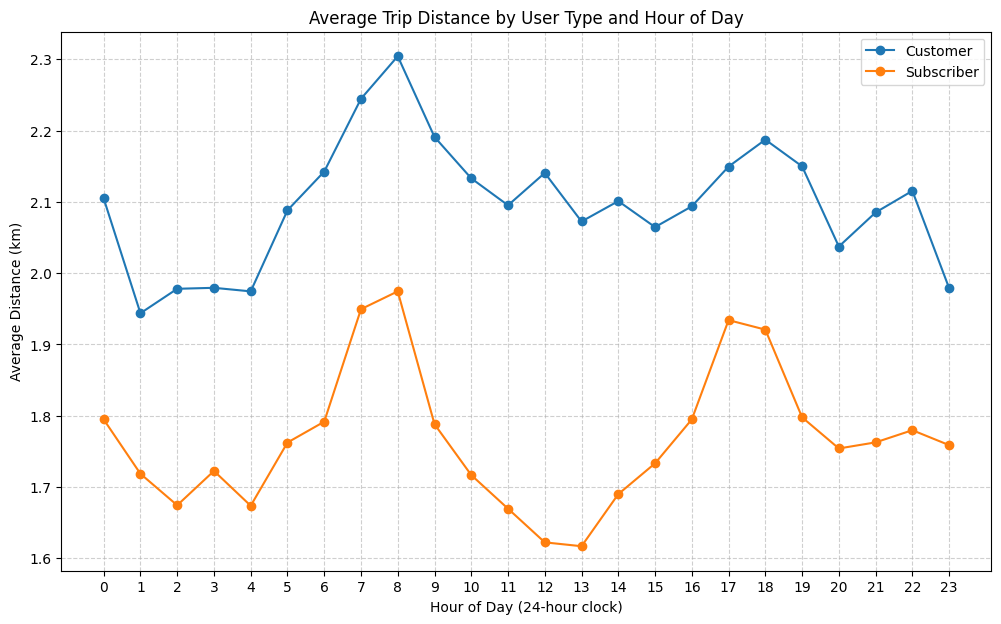

In [35]:
# Chart for Hypothesis B (Average Distance by User Type and Hour)
plt.figure(figsize=(12, 7))
for usertype in df_hyp_b['usertype'].unique():
    subset_df = df_hyp_b[df_hyp_b['usertype'] == usertype].sort_values(by='hour_of_day')
    plt.plot(subset_df['hour_of_day'], subset_df['average_distance_km'], marker='o', linestyle='-', label=usertype)

plt.xlabel('Hour of Day (24-hour clock)')
plt.ylabel('Average Distance (km)')
plt.title('Average Trip Distance by User Type and Hour of Day')
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

**Interpretation:** This line chart visualizes the average trip distance in kilometers throughout the 24 hours of the day, separated by user type (Customer and Subscriber). In general, it seems that casual users take lengthier trips than subscribers.

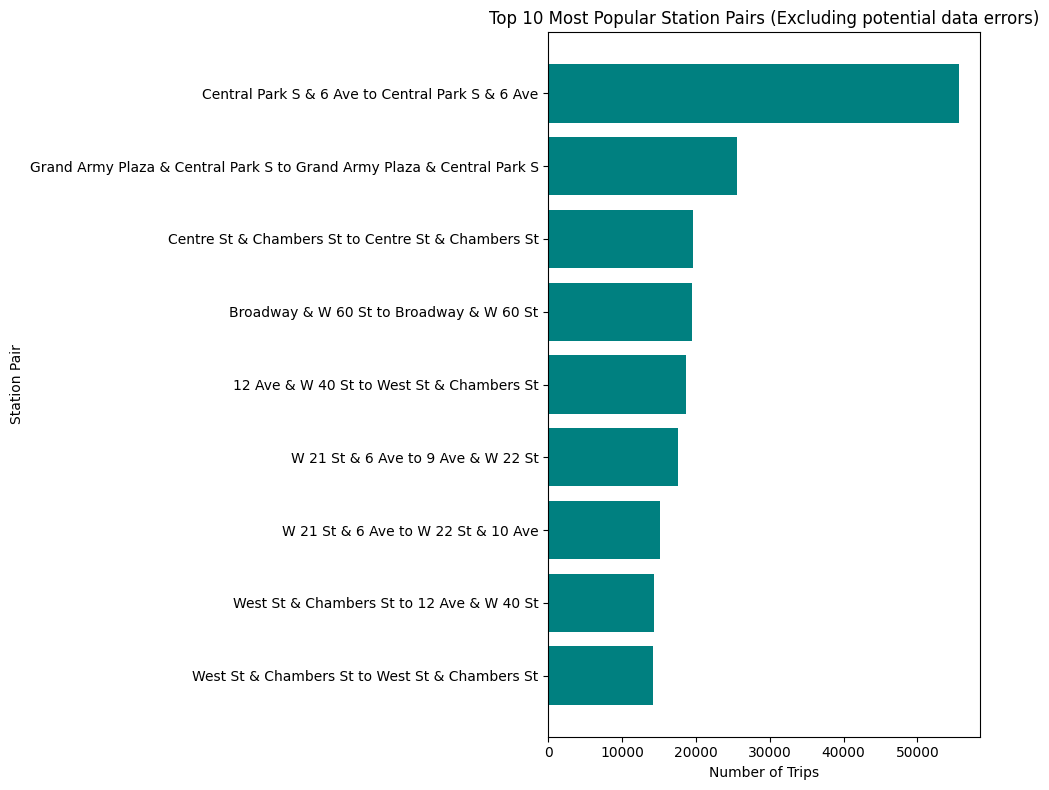

In [36]:
# Chart for Hypothesis C (Top 10 Most Popular Station Pairs)
# Exclude the first row with blank station names if it exists and has a very high count
df_hyp_c_filtered = df_hyp_c[df_hyp_c['rank'] > 1] if not df_hyp_c.empty and df_hyp_c.iloc[0]['rank'] == 1 and (df_hyp_c.iloc[0]['start_station_name'] == '' or df_hyp_c.iloc[0]['end_station_name'] == '') else df_hyp_c.head(10)

station_pairs = df_hyp_c_filtered['start_station_name'] + ' to ' + df_hyp_c_filtered['end_station_name']

plt.figure(figsize=(10, 8))
plt.barh(station_pairs, df_hyp_c_filtered['trip_count'], color='teal')
plt.xlabel('Number of Trips')
plt.ylabel('Station Pair')
plt.title('Top 10 Most Popular Station Pairs (Excluding potential data errors)')
plt.gca().invert_yaxis() # Display the highest count at the top
plt.tight_layout()
plt.show()

**Interactive Plotly Graph**

In [37]:
import plotly.express as px

# Chart for Hypothesis C (Top 10 Most Popular Station Pairs) using Plotly
# Exclude the first row with blank station names if it exists and has a very high count
df_hyp_c_filtered = df_hyp_c[df_hyp_c['rank'] > 1] if not df_hyp_c.empty and df_hyp_c.iloc[0]['rank'] == 1 and (df_hyp_c.iloc[0]['start_station_name'] == '' or df_hyp_c.iloc[0]['end_station_name'] == '') else df_hyp_c.head(10)

station_pairs = df_hyp_c_filtered['start_station_name'] + ' to ' + df_hyp_c_filtered['end_station_name']

fig = px.bar(
    df_hyp_c_filtered,
    x='trip_count',
    y=station_pairs,
    orientation='h',
    title='Top 10 Most Popular Station Pairs (Excluding potential data errors)'
)

fig.update_layout(
    xaxis_title='Number of Trips',
    yaxis_title='Station Pair'
)

fig.update_yaxes(autorange="reversed") # Display the highest count at the top

fig.show()

**Interpretation:** This horizontal bar chart displays the top 10 most popular station pairs based on the number of trips between them, excluding the potentially erroneous entry.

## 4) KPIs & Looker Studio Dashboard
- **KPI 1:** Trips by User Type Over Time
- **KPI 2:** Trip duration and count by Age
- **KPI 3:** Most travelled from station
- **KPI 4 (optional):** Trips by Gender

All of the KPIs above are visualised in the looker studio dashboard.

**Dashboard Link:** https://lookerstudio.google.com/reporting/902b4561-2a46-4d87-be78-fcd65f45efd6


## 5) Synthesis & Recommendations
Summarize your **top 3 insights** and provide **2–3 actionable recommendations** for NYC DOT.

**Insights:**
1. **Gender Imbalance:** From the output above, we can determine that males tend to make more trips using citi bikes when compared to females. We should take this finding with a grain of salt due to the existance of unknown values and missing data. This could be an area to look into further to determin why this difference exists.

2. **Difference in trip distances by User Type:** According to our findings above, customers seem to take loger trips on average when compared to subscribers. This might be because when customers do choose to pay to make a trip using citibike, they want to make the most out of it and therefore, use it longer while subscribers, since they use the service more often, do not feel the pressure to prolong their trip.

3. **Popular Stations:** A relatively small number of station pairings make up a large volume of trips. This hints at key routes that are popular in demand and might require more frequent bike rebalancing to ensure smooth processes. we should also take into account the large volume of missing data while interpreting this finding.

4. **Popular Times:** The most popular times that the citi bikes are being used according to the data is from 7 to 9 am and from 6 to 7 pm. This makes sense as these are the usual timings that children go to school and that office workers go to and come back from their offices.

**Actionable Recommendations:**
1. **Targeted Marketing Campaigns:** NYC DOT might want to focus on marketing campaigns that help make their services feel more accessible and safe for more female riders as well to adress the gender imbalance in terms of ridership.

2. **Proactive citi bike rebalancing:** Use the information collected regarding the most popular stations and times to actively rebalance bikes in these stations to avoid customer congestion. This will enable citibikes to be more readily availiable to all customers who want to use them.

3. **Collect more accurate and usable data:** Find a way to minimize and account for missing and null values to make the data more usable.

4. **Incentives for Subscribers:** Provide more compelling incentives for casual customers to become subscribers to promote brand loyalty and reduce the churn rate.

## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

| # | Prompt (summary) | Where used | What changed after refinement? |
|---|------------------|------------|--------------------------------|
| 1 | Give me a SQL query exploring the following question: Is there a difference in trip patterns between male and female riders? Why we're looking into this: This could reveal insights for targeted marketing or service adjustments. SQL Hint: Use COUNT(*) and GROUP BY gender and potentially include time-based grouping. Here's the FROM query we will use to access the data: FROM bigquery-public-data.new_york_citibike.citibike_trips | Hyp A | This query initially faced an error with the type of the gender column but gemini recognised and fixed the error. I didn't have to make any specific modifications to my prompt but in the future, I would specify that it compares this column to a string value. |
| 2 | My Prompt: Give me a SQL query exploring the following question: What is the average distance traveled per trip, and how does it vary by user type and time of day?Arrange the average distance column in descending order. Use CTEs Why we're exploring this question: This can provide insights into how the service is being used for commuting versus leisure. SQL Hint: You would need to calculate distance from station coordinates or use available distance data if present, then use AVG() and GROUP BY usertype, EXTRACT(HOUR FROM starttime). Here's the FROM query we will use to access the data: FROM bigquery-public-data.new_york_citibike.citibike_trips | Hyp B | This prompt ran without me having to change anything. I did end up modifying the promt to ask it to use CTEs. |
| 3 | Give me a SQL query exploring the following question: Are there specific station pairs (start to end) that are significantly more popular than others? why we're exploring this: This can highlight key routes and inform station capacity planning. SQL Hint: Use COUNT(*) and GROUP BY start_station_name, end_station_name and order by count. Use CTEs and at least one window function. Here's the FROM query we will use to access the data: FROM bigquery-public-data.new_york_citibike.citibike_trips | Hyp C | This prompt faced an error that the PI() function isn't availiable in BigQuery so had to modify the prompt asking it not to use that. Then making sure there are no floating point errors when there is the same start and end station.|

## DIVE Reflection:

**D (Discover):** The analysis discovered KPIs through SQL queries that utilized CTEs and window functions.

**I (Investigate):** The investigation explored the data from different perspectives by examining gender differences, trip distances over time, and popular station routes, all framed within the business context of improving Citi Bike services for NYC DOT.

**V (Validate):** The process involved validating findings and addressing errors encountered during query execution to ensure the results are as true as possible.

**E (Extend):** The project was extended by including an interactive Plotly visualisation alosng with an individual looker studio dashboard visualising the KPIs. The notebook also includes a summarized version of insights and actionable recommendations.

## 📦 Appendix — Reproducibility
- BigQuery location: It's a BigQuery Public Dataset: `bigquery-public-data.new_york_citibike.citibike_trips`
- Query costs observed (if any): Since the first TB processed per month is free, there are no associated costs for me that I know of.
- Known data quality caveats: Alot of unknown or missing values. Incorrect collection of data, especially if some datapoints depend on self reporting from customers.